In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import FOLPSD as FOLPS
from classy import Class
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import CubicSpline
import os, h5py

In [3]:
# !pwd

In [4]:
# !ls /Users/waco/Pub-DESI-2024-0477-DMP/data/common/windowed/

In [5]:
#functions
k_window=np.array([0.00269279, 0.0029257 , 0.00317876, 0.0034537 , 0.00375242,
       0.00407698, 0.00442961, 0.00481274, 0.005229  , 0.00568128,
       0.00617267, 0.00670656, 0.00728664, 0.00791688, 0.00860164,
       0.00934562, 0.01015395, 0.0110322 , 0.01198641, 0.01302315,
       0.01414956, 0.0153734 , 0.0167031 , 0.0181478 , 0.01971746,
       0.02142289, 0.02327582, 0.02528902, 0.02747635, 0.02985286,
       0.03243493, 0.03524033, 0.03828838, 0.04160006, 0.04519818,
       0.04910752, 0.05335498, 0.05796982, 0.06298381, 0.06843148,
       0.07435034, 0.08078113, 0.08776815, 0.09535949, 0.10360744,
       0.11256877, 0.1223052 , 0.13288376, 0.1443773 , 0.15686495,
       0.17043269, 0.18517396, 0.20119024, 0.21859182, 0.23749851,
       0.25804051, 0.28035925, 0.30460841, 0.33095495, 0.35958029,
       0.39068152, 0.4244728 , 0.4611868 , 0.5010763 ])

def reconstruct_symmetric(Btri, Nk):
    i, j = np.tril_indices(Nk)
    B = np.zeros((Nk, Nk))
    B[i, j] = Btri
    B[j, i] = Btri
    return B


def reconstruct_B202_B022(B202_tri, B022_tri, Nk):
    i, j = np.tril_indices(Nk)

    B202 = np.zeros((Nk, Nk))
    B022 = np.zeros((Nk, Nk))

    # Lower triangle (direct)
    B202[i, j] = B202_tri
    B022[i, j] = B022_tri

    # Upper triangle (cross-fill)
    B202[j, i] = B022_tri
    B022[j, i] = B202_tri

    return B202, B022



def HDF5_file_peep(wcmat_file):

    print('peep at file:')
    print(wcmat_file)
    print('')
    
    with h5py.File(wcmat_file, 'r') as f:
        print("=== File Structure ===")
        
        # Function to recursively print all groups and datasets
        def print_structure(name, obj):
            if isinstance(obj, h5py.Group):
                print(f"Group: {name}")
            elif isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}, shape: {obj.shape}, dtype: {obj.dtype}")
        
        f.visititems(print_structure)
        
        # Alternative: Simple listing
        print("\n=== Simple List ===")
        print(list(f.keys()))
        
        # Get more details about a specific item
        print("\n=== Details ===")
        for key in f.keys():
            item = f[key]
            if isinstance(item, h5py.Dataset):
                print(f"{key}: shape={item.shape}, dtype={item.dtype}")
                # print(f"    First few values: {item[:3] if len(item) > 0 else 'Empty'}")  

    return None


def convolve_B000_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,window_conv_matrix,
                     precision_full=[8,10,10], precision_diag=[12,15,15],
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='cubic',
                     use_full_diag=True,
                     get_windowed=True):
    
    k_ev = np.logspace(np.log10(k_window[0]), np.log10(k_window[-1]), num=Ssize)
    Nk = len(k_ev)
    i, j = np.tril_indices(Nk) # LOWER triangular indices (k1 >= k2)
    k1k2pairs = np.column_stack((k_ev[i], k_ev[j]))
        
    Bk2D = FOLPS.Sugiyama_Bl1l2L(k1k2pairs,bisp_nuis_params, bisp_cosmo_params, 
                         qpar, qperp, k_pkl_pklnw, 
                         precision=precision_full, 
                         f=f, 
                         renormalize=True, 
                         interpolation_method=interpolation_method_full)

    B000_2D, B110_2D, B220_2D, B202_2D, B022_2D, B112_2D = Bk2D
    
    B000_grid = reconstruct_symmetric(B000_2D, Nk)
    B110_grid = reconstruct_symmetric(B110_2D, Nk)
    B220_grid = reconstruct_symmetric(B220_2D, Nk)
    B112_grid = reconstruct_symmetric(B112_2D, Nk)
    
    B202_grid, B022_grid = reconstruct_B202_B022(
        B202_2D, B022_2D, Nk
    )


    if Ssize == len(k_window):
        Bl1l2L=np.array([B000_2D,B110_2D,B220_2D,B202_2D])
        combined = np.concatenate([arr.flatten() for arr in Bl1l2L], axis=0)
        B000_convolved_model = np.dot(window_conv_matrix, combined)
        B000_convolved_diagonal = np.diag(B000_convolved_model.reshape(len(k_ev),len(k_ev)))
        return Bl1l2L

    
    K1_new, K2_new = np.meshgrid(k_ev, k_ev)   
    pairs_new = np.column_stack([K1_new.ravel(), K2_new.ravel()])
    
    
    k1k2pairs_new=pairs_new
    
    spline = RectBivariateSpline(k_ev, k_ev, B000_grid, kx=3, ky=3)
    B000_2D = spline(k_window, k_window)
    
    spline = RectBivariateSpline(k_ev, k_ev, B110_grid, kx=3, ky=3)
    B110_2D = spline(k_window, k_window)
    
    spline = RectBivariateSpline(k_ev, k_ev, B220_grid, kx=3, ky=3)
    B220_2D = spline(k_window, k_window)
    
    spline = RectBivariateSpline(k_ev, k_ev, B202_grid, kx=3, ky=3)
    B202_2D = spline(k_window, k_window)
    
    spline = RectBivariateSpline(k_ev, k_ev, B022_grid, kx=3, ky=3)
    B022_2D = spline(k_window, k_window)

    if get_windowed==False:
        return B000_2D.diagonal()


    if use_full_diag:
        k_window 
        k_ev_bk=np.vstack([k_window,k_window]).T   # List of pairs of k. (B=B(k1,k2))
        precision=[10,10,10]
        k1k2pairs=k_ev_bk
        Bkdiag = FOLPS.Sugiyama_Bl1l2L(k1k2pairs,bisp_nuis_params, bisp_cosmo_params, 
                             qpar, qperp, k_pkl_pklnw, 
                             precision=precision_diag, 
                             f=f, 
                             renormalize=renormalize, 
                             interpolation_method=interpolation_method_diag)  
    
        B000_diag, B110_diag, B220_diag, B202_diag, B022_diag, B112_diag = Bkdiag
        
        np.fill_diagonal(B000_2D, B000_diag)
        np.fill_diagonal(B110_2D, B110_diag)
        np.fill_diagonal(B220_2D, B220_diag)
        np.fill_diagonal(B202_2D, B202_diag)
        np.fill_diagonal(B022_2D, B022_diag)
    
    
    Bl1l2L=np.array([B000_2D,B110_2D,B220_2D,B202_2D])

    combined = np.concatenate([arr.flatten() for arr in Bl1l2L], axis=0)
    B000_convolved_model = np.dot(window_conv_matrix, combined)
    B000_convolved_diagonal = np.diag(B000_convolved_model.reshape(len(k_window),len(k_window)))

    return B000_convolved_diagonal


def convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     window_conv_matrix_000, window_conv_matrix_202,
                     precision_full=[8,10,10], precision_diag=[8,10,10],
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='cubic',
                     use_full_diag=True,
                     get_windowed=True):
    
    k_ev = np.logspace(np.log10(k_window[0]), np.log10(k_window[-1]), num=Ssize)
    Nk = len(k_ev)
    i, j = np.tril_indices(Nk) # LOWER triangular indices (k1 >= k2)
    k1k2pairs = np.column_stack((k_ev[i], k_ev[j]))
        
    Bk2D = FOLPS.Sugiyama_Bl1l2L(k1k2pairs,bisp_nuis_params, bisp_cosmo_params, 
                         qpar, qperp, k_pkl_pklnw, 
                         precision=precision_full, 
                         f=f, 
                         renormalize=True, 
                         interpolation_method=interpolation_method_full)

    B000_2D, B110_2D, B220_2D, B202_2D, B022_2D, B112_2D = Bk2D
    
    B000_grid = reconstruct_symmetric(B000_2D, Nk)
    B110_grid = reconstruct_symmetric(B110_2D, Nk)
    B220_grid = reconstruct_symmetric(B220_2D, Nk)
    B112_grid = reconstruct_symmetric(B112_2D, Nk)
    
    B202_grid, B022_grid = reconstruct_B202_B022(
        B202_2D, B022_2D, Nk
    )

    
    K1_new, K2_new = np.meshgrid(k_ev, k_ev)   
    pairs_new = np.column_stack([K1_new.ravel(), K2_new.ravel()])
     
    k1k2pairs_new=pairs_new
    
    spline = RectBivariateSpline(k_ev, k_ev, B000_grid, kx=3, ky=3)
    B000_2D = spline(k_window, k_window)
    
    spline = RectBivariateSpline(k_ev, k_ev, B110_grid, kx=3, ky=3)
    B110_2D = spline(k_window, k_window)
    
    spline = RectBivariateSpline(k_ev, k_ev, B220_grid, kx=3, ky=3)
    B220_2D = spline(k_window, k_window)
    
    spline = RectBivariateSpline(k_ev, k_ev, B202_grid, kx=3, ky=3)
    B202_2D = spline(k_window, k_window)
    
    spline = RectBivariateSpline(k_ev, k_ev, B022_grid, kx=3, ky=3)
    B022_2D = spline(k_window, k_window)
    
    spline = RectBivariateSpline(k_ev, k_ev, B112_grid, kx=3, ky=3)
    B112_2D = spline(k_window, k_window)

    if get_windowed==False:
        return B000_2D.diagonal(), B202_2D.diagonal()


    if use_full_diag:
        k_window 
        k_ev_bk=np.vstack([k_window,k_window]).T   # List of pairs of k. (B=B(k1,k2))
        precision=[10,10,10]
        k1k2pairs=k_ev_bk
        Bkdiag = FOLPS.Sugiyama_Bl1l2L(k1k2pairs,bisp_nuis_params, bisp_cosmo_params, 
                             qpar, qperp, k_pkl_pklnw, 
                             precision=precision_diag, 
                             f=f, 
                             renormalize=renormalize, 
                             interpolation_method=interpolation_method_diag)  
    
        B000_diag, B110_diag, B220_diag, B202_diag, B022_diag, B112_diag = Bkdiag
        
        np.fill_diagonal(B000_2D, B000_diag)
        np.fill_diagonal(B110_2D, B110_diag)
        np.fill_diagonal(B220_2D, B220_diag)
        np.fill_diagonal(B202_2D, B202_diag)
        np.fill_diagonal(B022_2D, B022_diag)
    
    Bl1l2L=np.array([B000_2D,B110_2D,B220_2D,B202_2D])
    combined = np.concatenate([arr.flatten() for arr in Bl1l2L], axis=0)
    B000_convolved_model = np.dot(window_conv_matrix_000, combined)
    B000_convolved_diagonal = np.diag(B000_convolved_model.reshape(len(k_window),len(k_window)))
    
    Bl1l2L_for_202=np.array([B000_2D,B110_2D,B220_2D,B112_2D,B202_2D])
    combined = np.concatenate([arr.flatten() for arr in Bl1l2L_for_202], axis=0)
    B202_convolved_model = np.dot(window_conv_matrix_202, combined)
    B202_convolved_diagonal = np.diag(B202_convolved_model.reshape(len(k_window),len(k_window)))
    
    return B000_convolved_diagonal, B202_convolved_diagonal




In [6]:
# Data available at https://zenodo.org/records/15611866

# BASE_DIR = '/Users/austerlitz/TripoSH-Factory/my_project/debug/window'
TRACER = 'LRG1'
MULTIPOLE = '000'
CAP = 'SGC'
# DATA_DIR = '/global/cfs/cdirs/desicollab/users/aaviles/Pub-DESI-2024-0477-DMP/'

DATA_DIR = '/Users/waco/Pub-DESI-2024-0477-DMP/'

if (TRACER == 'LRG1') and (MULTIPOLE == '000') and (CAP == 'SGC'):
    file_000='wcmat_000_reduced_LRG_altmtl_SGC_0.4z0.6_mock0.h5'
    wcmat_file_000=DATA_DIR + 'data/common/winconv-matrices/'+ file_000
    window_file_000 = wcmat_file_000
    file_202='wcmat_202_reduced_LRG_altmtl_SGC_0.4z0.6_mock0.h5'
    wcmat_file_202=DATA_DIR + 'data/common/winconv-matrices/'+ file_202
    window_file_202 = wcmat_file_202
    z=0.5
    kw = np.load('c000.npy', allow_pickle=True).item()['k'] #this is the altmtl data

    
    
# with h5py.File(wcmat_file_000, "r") as f:
#     def print_structure(name, obj):
#         print(name, obj)       
#     f.visititems(print_structure)

with h5py.File(window_file_000, 'r') as f:
    wcmat_000 = f['wcmat'][:]
    # print('Shape:', wcmat.shape)
f.close()


with h5py.File(window_file_202, 'r') as f:
    wcmat_202 = f['wcmat'][:]
    # print('Shape:', wcmat.shape)
f.close()


HDF5_file_peep(wcmat_file_000)
print('')
HDF5_file_peep(wcmat_file_202)
print('')
# print('')
# print('c000.npy keys:', np.load('c000.npy', allow_pickle=True).item().keys())
# print('')
# print('altmtl number of data:', len(kw))
# k_window = np.loadtxt('k_window.txt')
# print(k_window.shape)
# k_window

peep at file:
/Users/waco/Pub-DESI-2024-0477-DMP/data/common/winconv-matrices/wcmat_000_reduced_LRG_altmtl_SGC_0.4z0.6_mock0.h5

=== File Structure ===
Dataset: wcmat, shape: (4096, 16384), dtype: float64

=== Simple List ===
['wcmat']

=== Details ===
wcmat: shape=(4096, 16384), dtype=float64

peep at file:
/Users/waco/Pub-DESI-2024-0477-DMP/data/common/winconv-matrices/wcmat_202_reduced_LRG_altmtl_SGC_0.4z0.6_mock0.h5

=== File Structure ===
Dataset: wcmat, shape: (4096, 20480), dtype: float64

=== Simple List ===
['wcmat']

=== Details ===
wcmat: shape=(4096, 20480), dtype=float64



In [7]:
#LRG1 Abacus 2nd Gen best fit cosmology
X_FoG_b = 1
h=0.677
omega_cdm=0.122
omega_b=0.02236
logAs = 3.03
X_FoG_p   = 1.56
b1   = 1.85
b2   = 0.32 
bs=-1.4
# b2= 8/21*(b1-1)
# bs2= -4/7*(b1-1)      
b3nl = 32/315*(b1 - 1);  
c1=-4
c2=-0.1
Pshot=-1820
Bshot = 5115
omega_ncdm = 0.06/96.4
ns=0.966

z_pk = 0.5;                 #evaluation redshift
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

bisp_nuis_params = [b1, b2, bs, c1,c2,Pshot,Bshot, X_FoG_b]
OmM=(omega_cdm+omega_b+omega_ncdm)/h**2
bisp_cosmo_params = [z_pk,OmM,h]

qpar,qperp=1,1

In [8]:
cosmo = Class()
# pass input parameters
cosmo.set({'omega_b':omega_b,'omega_cdm':omega_cdm,'h':h,'A_s':np.exp(logAs)*1e-10,'n_s':ns})
cosmo.set({'output':',mPk', 
           'P_k_max_1/Mpc':10.0,
           'z_pk': z_pk})
# run class
cosmo.compute()  # output is in 1/Mpc

k = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
Pk = [] # P(k) in (Mpc/h)**3
h = cosmo.h() # get reduced Hubble for conversions to 1/Mpc
for k_v in k:
    Pk.append(cosmo.pk(k_v*h,z_pk )*h**3) # pk(k,z) in h/Mpc

inputpkT = np.array([k, Pk])   

In [9]:
NuisanParamsPk = [b1, b2, bs, b3nl, 0,0,0, 0,0,0, 0,0]
Omfid = -1  # for AP set > 0
APtrue = False
matrices = FOLPS.Matrices()
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 100) # array of k_ev in [h/Mpc]
nonlinear = FOLPS.NonLinear(inputpkT, CosmoParams)
kh, pkl0, pkl2, pkl4 = FOLPS.RSDmultipoles(k_ev, NuisanParamsPk, qpar,qperp)  #We dont use this
k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[1][1]])



N = 128 sampling points
M matrices have been computed


In [10]:


dataaltmtl=np.load(DATA_DIR+'data/common/windowed/bk000_diag_LRG_altmtl_SGC_0.4z0.6_mocks.npy',allow_pickle=True)
data_dict = dataaltmtl.item()
print(data_dict.keys())

k_sims = data_dict['coords']
mean_sims = data_dict['stats_mean']
error_sims = data_dict['stats_std']
print(data_dict['source'])
print(k_sims.shape)


dataaltmtl_202=np.load(DATA_DIR+'data/common/windowed/bk202_diag_LRG_altmtl_SGC_0.4z0.6_mocks.npy',allow_pickle=True)
data_dict_202 = dataaltmtl_202.item()
print(data_dict_202.keys())

k_sims_202 = data_dict_202['coords']
mean_sims_202 = data_dict_202['stats_mean']
error_sims_202 = data_dict_202['stats_std']
print(data_dict_202['source'])
print(k_sims_202.shape)

dict_keys(['coords', 'coords_prime', 'coord_nyq', 'counts', 'stats', 'stats_sn', 'stats_mean', 'stats_std', 'source'])
/Users/mikesw/Documents/Documents/Projects/DESI-Clustering/storage/output/measurements/SurveyCatalogs/Y1-Mocks/SecondGenMocks/AbacusSummit_v4_2/by_ctlgname/LRG_altmtl_SGC_0.4z0.6/bk000_diag_LRG_altmtl_SGC_0.4z0.6_mock{:d}
(40,)
dict_keys(['coords', 'coords_prime', 'coord_nyq', 'counts', 'stats', 'stats_sn', 'stats_mean', 'stats_std', 'source'])
/Users/mikesw/Documents/Documents/Projects/DESI-Clustering/storage/output/measurements/SurveyCatalogs/Y1-Mocks/SecondGenMocks/AbacusSummit_v4_2/by_ctlgname/LRG_altmtl_SGC_0.4z0.6/bk202_diag_LRG_altmtl_SGC_0.4z0.6_mock{:d}
(40,)


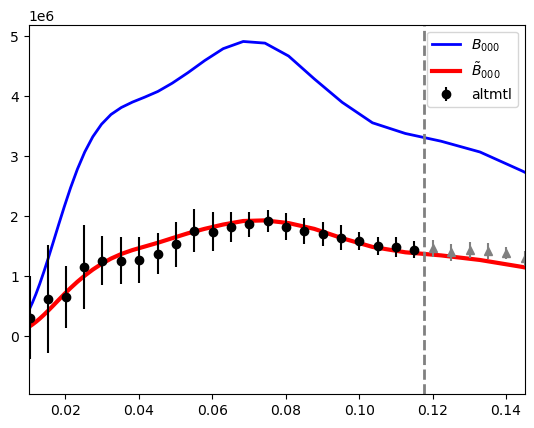

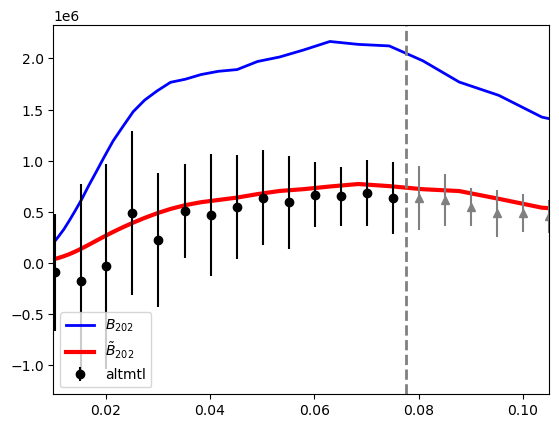

In [11]:
Ssize=20

window_conv_matrix_000=wcmat_000
window_conv_matrix_202=wcmat_202

B000_windowed, B202_windowed = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     wcmat_000, wcmat_202,
                     precision_full=[8,10,10], precision_diag=[12,15,15],
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='cubic',
                     use_full_diag=False)
Ssize=40
B000_unwindowed, B202_unwindowed = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     wcmat_000, wcmat_202,
                     precision_full=[8,10,10], precision_diag=[12,15,15],
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='cubic',
                     use_full_diag=False,
                     get_windowed=False)


tt=23
xmax=k_sims[tt+5]
plt.plot(kw,kw**2 * B000_unwindowed,label=r'$B_{000}$', color='blue', lw=2)
plt.plot(kw,kw**2 * B000_windowed  ,label=r'$\tilde{B}_{000}$', color='red', lw=3)
plt.errorbar(k_sims[:tt],k_sims[:tt]**2 * mean_sims[:tt],k_sims[:tt]**2*error_sims[:tt],label=r'altmtl',fmt='o', color='k')
plt.errorbar(k_sims[tt:],k_sims[tt:]**2 * mean_sims[tt:],k_sims[tt:]**2*error_sims[tt:],fmt='^', color='gray')
plt.axvline(x=(k_sims_202[tt-1]+k_sims_202[tt])/2, color='gray', linestyle='--', linewidth=2)


plt.xlim(0.01,xmax)
plt.legend()
plt.show()


tt=15
xmax=k_sims[tt+5]
plt.plot(kw,kw**2 * B202_unwindowed,label=r'$B_{202}$', color='blue', lw=2)
plt.plot(kw,kw**2 * B202_windowed  ,label=r'$\tilde{B}_{202}$', color='red', lw=3)
plt.errorbar(k_sims_202[:tt],k_sims_202[:tt]**2 * mean_sims_202[:tt],k_sims_202[:tt]**2*error_sims_202[:tt],label=r'altmtl',fmt='o', color='k')
plt.errorbar(k_sims_202[tt:],k_sims_202[tt:]**2 * mean_sims_202[tt:],k_sims_202[tt:]**2*error_sims_202[tt:],fmt='^', color='gray')
plt.axvline(x=(k_sims_202[tt-1]+k_sims_202[tt])/2, color='gray', linestyle='--', linewidth=2)


plt.xlim(0.01,xmax)
plt.legend()
plt.show()

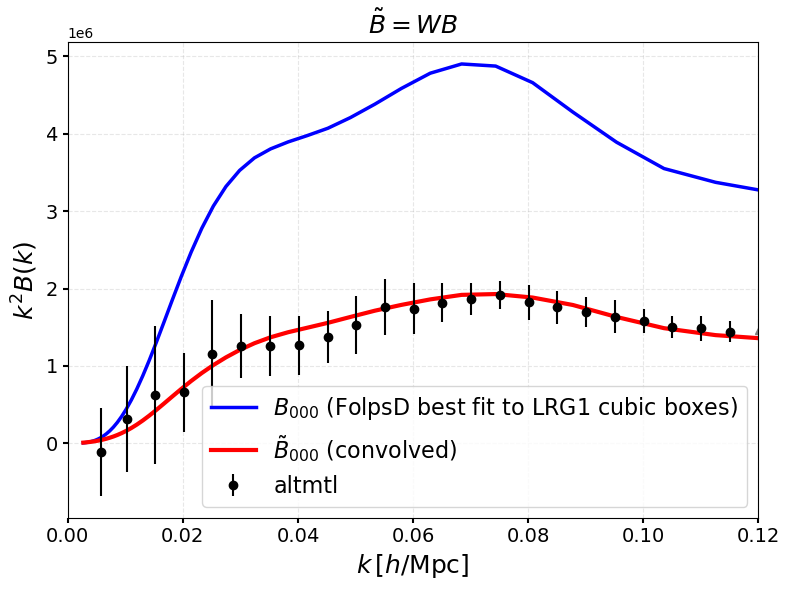

In [12]:
plt.figure(figsize=(8,6))

plt.plot(kw, kw**2 * B000_unwindowed,
         label=r'$B_{000}$ (FolpsD best fit to LRG1 cubic boxes)', color='blue', lw=2.5)

plt.plot(kw, kw**2 * B000_windowed,
         label=r'$\tilde{B}_{000}$ (convolved)', color='red', lw=3)

tt=23
plt.errorbar(k_sims[:tt],k_sims[:tt]**2 * mean_sims[:tt],k_sims[:tt]**2*error_sims[:tt],
             label=r'altmtl',fmt='o', color='k', markersize=6)
plt.errorbar(k_sims[tt:],k_sims[tt:]**2 * mean_sims[tt:],k_sims[tt:]**2*error_sims[tt:],
             fmt='^', color='gray', markersize=6)

# Styling 
plt.xlim(0.0, 0.12)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$', fontsize=18)
plt.ylabel(r'$k^2 B(k)$', fontsize=18)
plt.title(r'$\tilde{B} = W B$', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=14, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize=16, frameon=True)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("B000_diag_windowed.pdf", bbox_inches="tight")
plt.show()

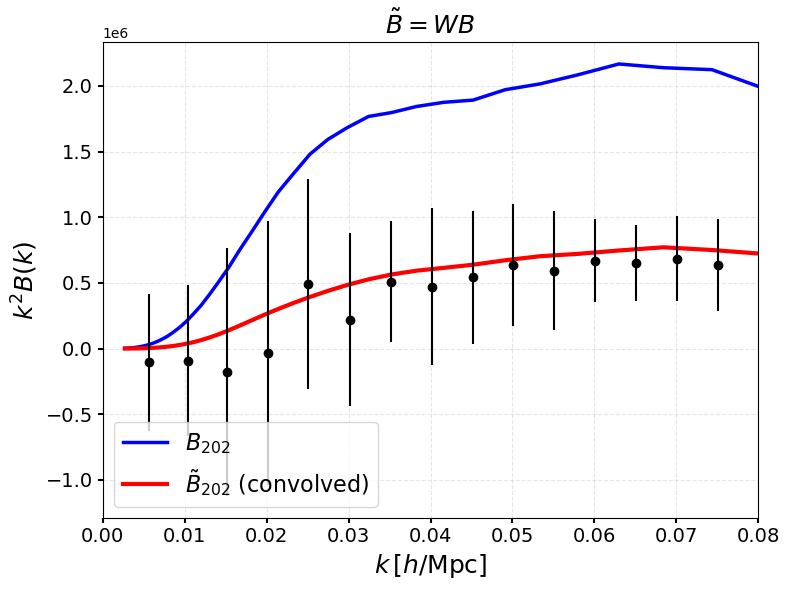

In [13]:
plt.figure(figsize=(8,6))

plt.plot(kw, kw**2 * B202_unwindowed,
         label=r'$B_{202}$', color='blue', lw=2.5)
plt.plot(kw, kw**2 * B202_windowed,
         label=r'$\tilde{B}_{202}$ (convolved)', color='red', lw=3)

plt.xlim(0.00, 0.08)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$', fontsize=18)
plt.ylabel(r'$k^2 B(k)$', fontsize=18)
plt.title(r'$\tilde{B} = W B$', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=14, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(fontsize=16, frameon=True)


tt=15
plt.errorbar(k_sims_202[:tt],k_sims_202[:tt]**2 * mean_sims_202[:tt],k_sims_202[:tt]**2*error_sims_202[:tt],label=r'altmtl',fmt='o', color='k')

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("B202_diag_windowed.pdf", bbox_inches="tight")
plt.show()

# test precision and times

In [16]:
%%time
Ssize=60
B000_maxprec, B202_maxprec = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     wcmat_000,wcmat_202,
                     precision_full=[32,32,32], precision_diag=[32,32,32],
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='cubic',
                     interpolation_method_diag='cubic',
                     use_full_diag=True)

CPU times: user 11.2 s, sys: 8.58 s, total: 19.7 s
Wall time: 22.2 s


In [17]:
%%time
Ssize=20

B000_linearDiag, B202_linearDiag = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     wcmat_000,wcmat_202,
                     precision_full=[8,10,10], precision_diag=[12,15,15],
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='linear',
                     use_full_diag=True)

CPU times: user 140 ms, sys: 11.1 ms, total: 151 ms
Wall time: 57.3 ms


In [18]:
%%time
Ssize=20
B000_cubicDiag, B202_cubicDiag = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     wcmat_000,wcmat_202,
                     precision_full=[8,10,10], precision_diag=[12,15,15],
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='cubic',
                     use_full_diag=True)

CPU times: user 158 ms, sys: 8.6 ms, total: 167 ms
Wall time: 64.3 ms


precision doesnt change between linear and cubic Plin interpolation


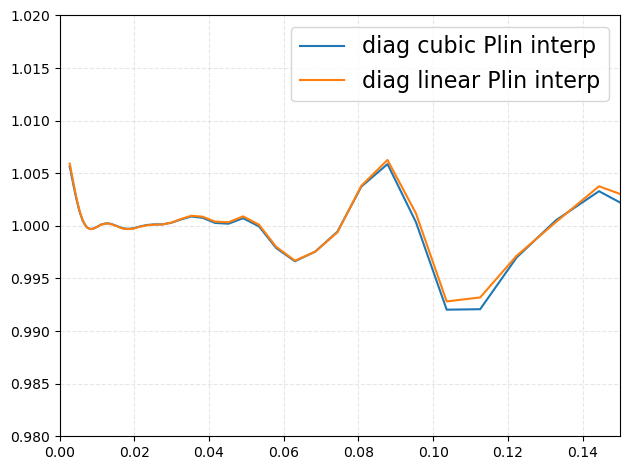

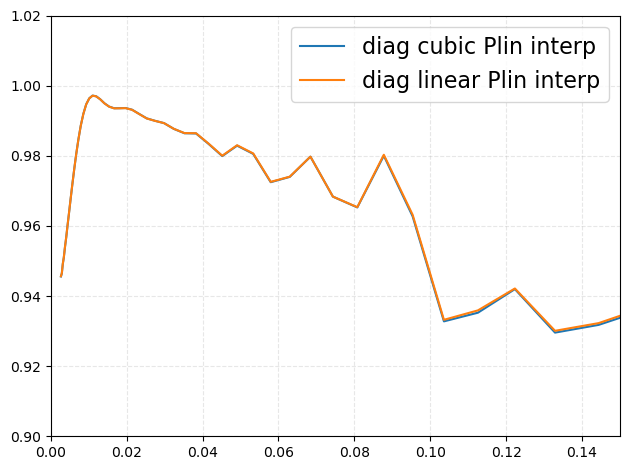

In [19]:
print('precision doesnt change between linear and cubic Plin interpolation')

plt.plot(kw,B000_cubicDiag/B000_maxprec,label=r'diag cubic Plin interp')
plt.plot(kw,B000_linearDiag/B000_maxprec,label=r'diag linear Plin interp')
plt.xlim(0,0.15)
plt.ylim(0.98,1.02)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=16, frameon=True)
plt.tight_layout()
plt.show()

plt.plot(kw,B202_cubicDiag/B202_maxprec,label=r'diag cubic Plin interp')
plt.plot(kw,B202_linearDiag/B202_maxprec,label=r'diag linear Plin interp')
plt.xlim(0,0.15)
plt.ylim(0.9,1.02)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=16, frameon=True)
plt.tight_layout()
plt.show()



In [20]:
# precision doesnt change between linear and cubic diagonal

In [21]:
precision_diag=[12,15,15]
precision_full=[8,10,10]

Ssize=15
start_time = time.time()
B000_15, B202_15 = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     wcmat_000,wcmat_202,
                     precision_full=precision_full, precision_diag=precision_diag,
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='linear',
                     use_full_diag=True)
print("--- %s seconds ---" % (time.time() - start_time))

Ssize=20
start_time = time.time()
B000_20, B202_20 = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     wcmat_000,wcmat_202,
                     precision_full=precision_full, precision_diag=precision_diag,
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='linear',
                     use_full_diag=True)
print("--- %s seconds ---" % (time.time() - start_time))

Ssize=30
start_time = time.time()
B000_30, B202_30 = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     wcmat_000,wcmat_202,
                     precision_full=precision_full, precision_diag=precision_diag,
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='linear',
                     use_full_diag=True)
print("--- %s seconds ---" % (time.time() - start_time))

Ssize=40
start_time = time.time()
B000_40, B202_40 = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     wcmat_000,wcmat_202,
                     precision_full=precision_full, precision_diag=precision_diag,
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='linear',
                     use_full_diag=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.043374061584472656 seconds ---
--- 0.04894900321960449 seconds ---
--- 0.0775611400604248 seconds ---
--- 0.11285924911499023 seconds ---


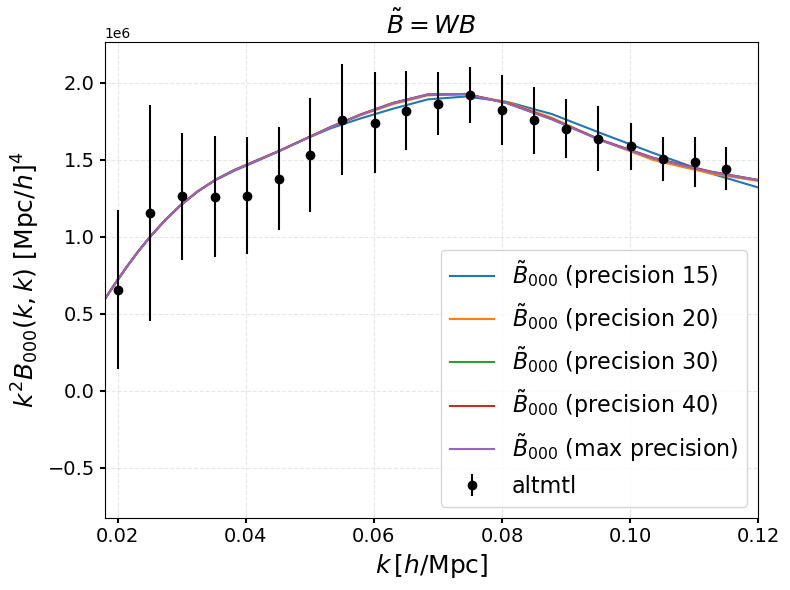

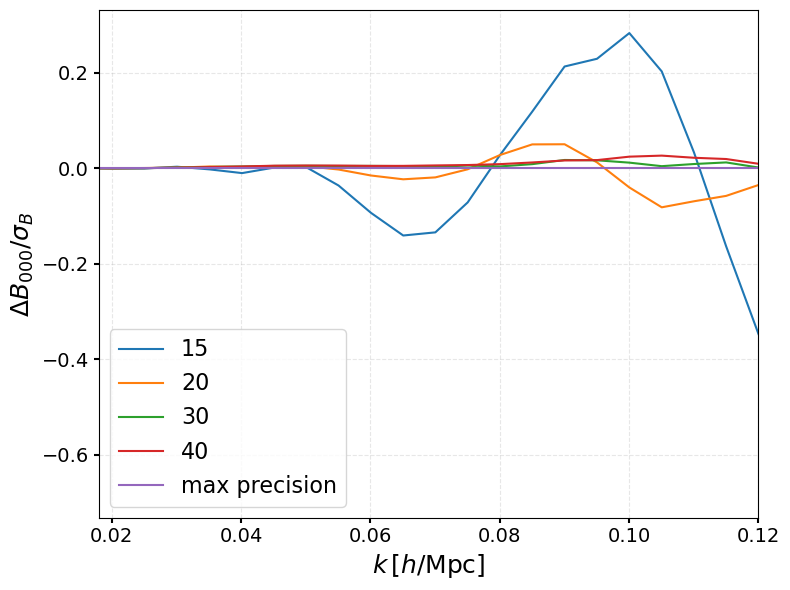

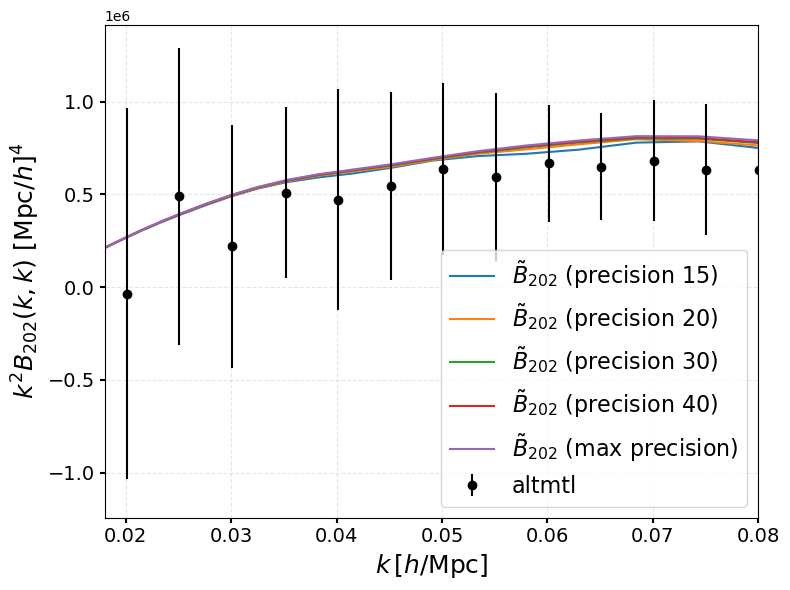

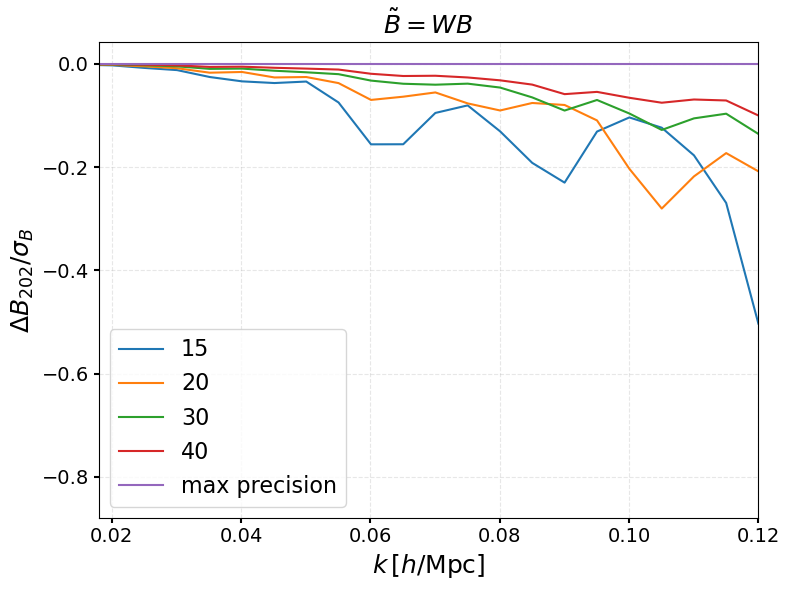

In [22]:
plt.figure(figsize=(8,6))



plt.plot(kw, kw**2 * B000_15,
         label=r'$\tilde{B}_{000}$ (precision 15)')
plt.plot(kw, kw**2 * B000_20,
         label=r'$\tilde{B}_{000}$ (precision 20)')
plt.plot(kw, kw**2 * B000_30,
         label=r'$\tilde{B}_{000}$ (precision 30)')
plt.plot(kw, kw**2 * B000_40,
         label=r'$\tilde{B}_{000}$ (precision 40)')
plt.plot(kw, kw**2 * B000_maxprec,
         label=r'$\tilde{B}_{000}$ (max precision)')

tt=23
plt.errorbar(k_sims[:tt],k_sims[:tt]**2 * mean_sims[:tt],k_sims[:tt]**2*error_sims[:tt],
             label=r'altmtl',fmt='o', color='k', markersize=6)

plt.xlim(0.018, 0.12)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$', fontsize=18)
plt.ylabel(r'$k^2 B_{000}(k,k)\, \,[\mathrm{Mpc}/h]^4$', fontsize=18)
plt.title(r'$\tilde{B} = W B$', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=14, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize=16, frameon=True)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("B000_diag_windowed.pdf", bbox_inches="tight")
plt.show()



plt.figure(figsize=(8,6))

B000_15_ksims = CubicSpline(kw, B000_15, bc_type='natural')(k_sims)
B000_20_ksims = CubicSpline(kw, B000_20, bc_type='natural')(k_sims)
B000_30_ksims = CubicSpline(kw, B000_30, bc_type='natural')(k_sims)
B000_40_ksims = CubicSpline(kw, B000_40, bc_type='natural')(k_sims)
B000_maxprec_ksims = CubicSpline(kw, B000_maxprec, bc_type='natural')(k_sims)


plt.plot(k_sims,(B000_15_ksims-B000_maxprec_ksims)/error_sims,label=r'15')
plt.plot(k_sims,(B000_20_ksims-B000_maxprec_ksims)/error_sims,label=r'20')
plt.plot(k_sims,(B000_30_ksims-B000_maxprec_ksims)/error_sims,label=r'30')
plt.plot(k_sims,(B000_40_ksims-B000_maxprec_ksims)/error_sims,label=r'40')
plt.plot(k_sims,(B000_maxprec_ksims-B000_maxprec_ksims)/error_sims,label=r'max precision')

# plt.plot(k_sims,np.array([0]*ll),ls='-.',color='k')
# plt.plot(k_sims,np.array([-0.25]*ll),ls='-.',color='gray')
# plt.plot(k_sims,np.array([-0.25]*ll),ls='-.',color='gray')
# plt.plot(k_sims,np.array([0.5]*ll),ls=':',color='gray')
# plt.plot(k_sims,np.array([-0.5]*ll),ls=':',color='gray')
plt.xlim(0.018, 0.12)
# plt.ylim(-0.6,0.6)


plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$', fontsize=18)
plt.ylabel(r'$\Delta B_{000}/\sigma_B$', fontsize=18)
# plt.title(r'$\tilde{B} = W B$', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=14, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize=16, frameon=True)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
# plt.savefig("B000_diag_windowed.pdf", bbox_inches="tight")

plt.show()






plt.figure(figsize=(8,6))



plt.plot(kw, kw**2 * B202_15,
         label=r'$\tilde{B}_{202}$ (precision 15)')
plt.plot(kw, kw**2 * B202_20,
         label=r'$\tilde{B}_{202}$ (precision 20)')
plt.plot(kw, kw**2 * B202_30,
         label=r'$\tilde{B}_{202}$ (precision 30)')
plt.plot(kw, kw**2 * B202_40,
         label=r'$\tilde{B}_{202}$ (precision 40)')
plt.plot(kw, kw**2 * B202_maxprec,
         label=r'$\tilde{B}_{202}$ (max precision)')

plt.errorbar(k_sims_202[tt:],k_sims_202[tt:]**2 * mean_sims_202[tt:],k_sims_202[tt:]**2*error_sims_202[tt:],
             fmt='^', color='gray', markersize=6)



plt.errorbar(k_sims_202[:tt],k_sims_202[:tt]**2 * mean_sims_202[:tt],k_sims_202[:tt]**2*error_sims_202[:tt],label=r'altmtl',fmt='o', color='k')

# Styling
plt.xlim(0.018, 0.08)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$', fontsize=18)
plt.ylabel(r'$k^2 B_{202}(k,k)\, \,[\mathrm{Mpc}/h]^4$', fontsize=18)
# plt.title(r'$\tilde{B} = W B$', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=14, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize=16, frameon=True)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("B202_diag_windowed.pdf", bbox_inches="tight")
plt.show()



plt.figure(figsize=(8,6))

B202_15_ksims = CubicSpline(kw, B202_15, bc_type='natural')(k_sims)
B202_20_ksims = CubicSpline(kw, B202_20, bc_type='natural')(k_sims)
B202_30_ksims = CubicSpline(kw, B202_30, bc_type='natural')(k_sims)
B202_40_ksims = CubicSpline(kw, B202_40, bc_type='natural')(k_sims)
B202_maxprec_ksims = CubicSpline(kw, B202_maxprec, bc_type='natural')(k_sims)


plt.plot(k_sims,(B202_15_ksims-B202_maxprec_ksims)/error_sims_202,label=r'15')
plt.plot(k_sims,(B202_20_ksims-B202_maxprec_ksims)/error_sims_202,label=r'20')
plt.plot(k_sims,(B202_30_ksims-B202_maxprec_ksims)/error_sims_202,label=r'30')
plt.plot(k_sims,(B202_40_ksims-B202_maxprec_ksims)/error_sims_202,label=r'40')
plt.plot(k_sims,(B202_maxprec_ksims-B202_maxprec_ksims)/error_sims_202,label=r'max precision')

# plt.plot(k_sims,np.array([0]*ll),ls='-.',color='k')
# plt.plot(k_sims,np.array([-0.25]*ll),ls='-.',color='gray')
# plt.plot(k_sims,np.array([-0.25]*ll),ls='-.',color='gray')
# plt.plot(k_sims,np.array([0.5]*ll),ls=':',color='gray')
# plt.plot(k_sims,np.array([-0.5]*ll),ls=':',color='gray')
plt.xlim(0.018, 0.12)
# plt.ylim(-0.6,0.6)


plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$', fontsize=18)
plt.ylabel(r'$\Delta B_{202}/\sigma_B$', fontsize=18)
plt.title(r'$\tilde{B} = W B$', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=14, width=1.5)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize=16, frameon=True)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
# plt.savefig("B000_diag_windowed.pdf", bbox_inches="tight")

plt.show()


# Recommended

In [62]:
%%time
Ssize=20
B000_20, B202_20 = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                     wcmat_000,wcmat_202,
                     precision_full=[8,10,10], precision_diag=[12,15,15],
                     f=None, 
                     renormalize=True, 
                     interpolation_method_full='linear',
                     interpolation_method_diag='linear',
                     use_full_diag=True)

CPU times: user 175 ms, sys: 20.6 ms, total: 196 ms
Wall time: 88.1 ms


In [67]:
start_time = time.time()
for i in range(100):
    B000_20, B202_20 = convolve_B000_B202_diag(bisp_nuis_params, bisp_cosmo_params, 
                         qpar, qperp, k_pkl_pklnw, k_window, Ssize,
                         wcmat_000,wcmat_202,
                         precision_full=[12,15,15], precision_diag=[12,15,15],
                         f=None, 
                         renormalize=True, 
                         interpolation_method_full='linear',
                         interpolation_method_diag='linear',
                         use_full_diag=True)

print("--- %s seconds ---" % (time.time() - start_time))


--- 9.892457008361816 seconds ---
